In [83]:
!pip install tf-keras transformers tensorflow statsmodels seaborn scikit-learn > Null

In [84]:
import pandas as pd
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Stocks data

In [85]:
import pandas as pd

product_name = 'ICLN'
prices_df = pd.read_csv(f'datasets/{product_name}.csv')

print(f'Number of rows: {prices_df.shape[0]}')
print(f'Missing values: {prices_df["Close"].isnull().sum()}')


# Convert the 'Date' column in prices_df to datetime
prices_df['Date'] = pd.to_datetime(prices_df['Date']).dt.date


# Set 'Date' as the index
prices_df.set_index('Date', inplace=True)

# Reindex to business days to fill missing dates
business_days = pd.bdate_range(start=prices_df.index.min(), end=prices_df.index.max())
prices_df = prices_df.reindex(business_days)

# Fill missing values (e.g., forward fill)
prices_df = prices_df.ffill()

print(f'first date: {prices_df.index.min()}')
print(f'last date: {prices_df.index.max()}')

prices_df.tail()

Number of rows: 4035
Missing values: 0
first date: 2008-06-25 00:00:00
last date: 2024-07-08 00:00:00


,Open,High,Low,Close,Adj Close,Volume
2024-07-02,13.26,13.42,13.18,13.26,13.26,2154900.0
2024-07-03,13.36,13.64,13.34,13.59,13.59,4990500.0
2024-07-04,13.36,13.64,13.34,13.59,13.59,4990500.0
2024-07-05,13.56,13.73,13.53,13.61,13.61,2619900.0
2024-07-08,13.58,13.73,13.55,13.70,13.70,4238997.0


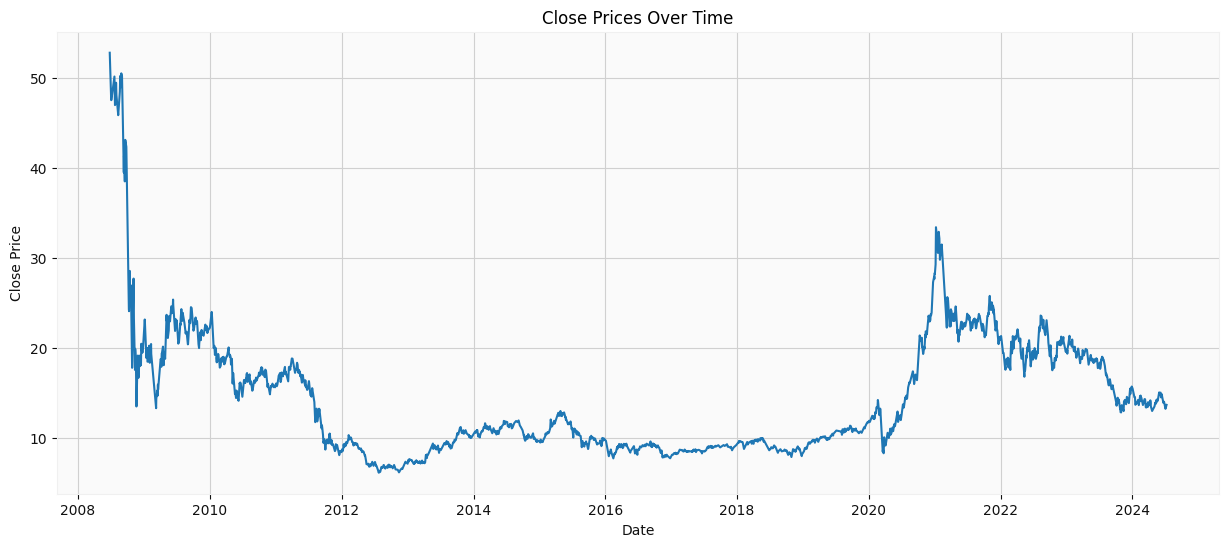

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the 'Close' column
plt.figure(figsize=(15, 6))
sns.lineplot(data=prices_df, x=prices_df.index, y='Close')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Prices Over Time')
plt.show()


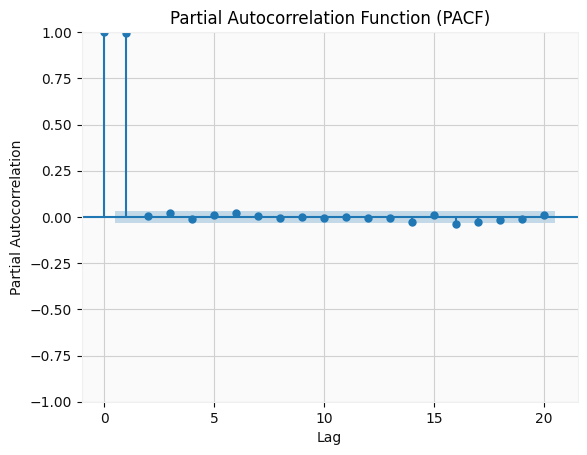

PACF Scores:
Lag 0: 1.0
Lag 1: 0.9948274244337907
Lag 2: 0.0076852692789298955
Lag 3: 0.020783250452186035
Lag 4: -0.011007247103308996
Lag 5: 0.013196605613297007
Lag 6: 0.020924650141199364
Lag 7: 0.008025842826467846
Lag 8: -0.0037719900729677987
Lag 9: 0.00209127359799035
Lag 10: -0.007647865357595332
Lag 11: 0.0019161523672270014
Lag 12: -0.007190719388653563
Lag 13: -0.005983146289337068
Lag 14: -0.026939997351142025
Lag 15: 0.010138808846247611
Lag 16: -0.03949588830705335
Lag 17: -0.03024087226781524
Lag 18: -0.01856871882317833
Lag 19: -0.012610656596675084
Lag 20: 0.010755463044629342


In [87]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf

# Calculate PACF
pacf_scores = pacf(prices_df['Close'], nlags=20)

# Plot PACF
plot_pacf(prices_df['Close'], lags=20)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

# Print PACF scores
print("PACF Scores:")
for lag, score in enumerate(pacf_scores):
    print(f"Lag {lag}: {score}")

We can see that Lag 1 prices are the most correlated with the current price

## Additional Features

Technical features

In [88]:
#Lagged Features
# Create lag columns for 'Close', 'Open', 'High', 'Low'
prices_df['Close_Lag1'] = prices_df['Close'].shift(1)
prices_df['Open_Lag1'] = prices_df['Open'].shift(1)
prices_df['High_Lag1'] = prices_df['High'].shift(1)
prices_df['Low_Lag1'] = prices_df['Low'].shift(1)

# Technical Indicators
# Moving Averages
prices_df['SMA_5'] = prices_df['Close'].rolling(window=5).mean()
prices_df['SMA_10'] = prices_df['Close'].rolling(window=10).mean()
prices_df['SMA_20'] = prices_df['Close'].rolling(window=20).mean()
prices_df['SMA_100'] = prices_df['Close'].rolling(window=100).mean()

# Relative Strength Index (RSI)
def compute_rsi(data, window):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi
prices_df['RSI_14'] = compute_rsi(prices_df['Close'], 14)

# Bollinger Bands
prices_df['BB_middle'] = prices_df['Close'].rolling(window=20).mean()
prices_df['BB_std'] = prices_df['Close'].rolling(window=20).std()
prices_df['BB_upper'] = prices_df['BB_middle'] + (prices_df['BB_std'] * 2)
prices_df['BB_lower'] = prices_df['BB_middle'] - (prices_df['BB_std'] * 2)

# Momentum
prices_df['MOM_10'] = prices_df['Close'].diff(10)


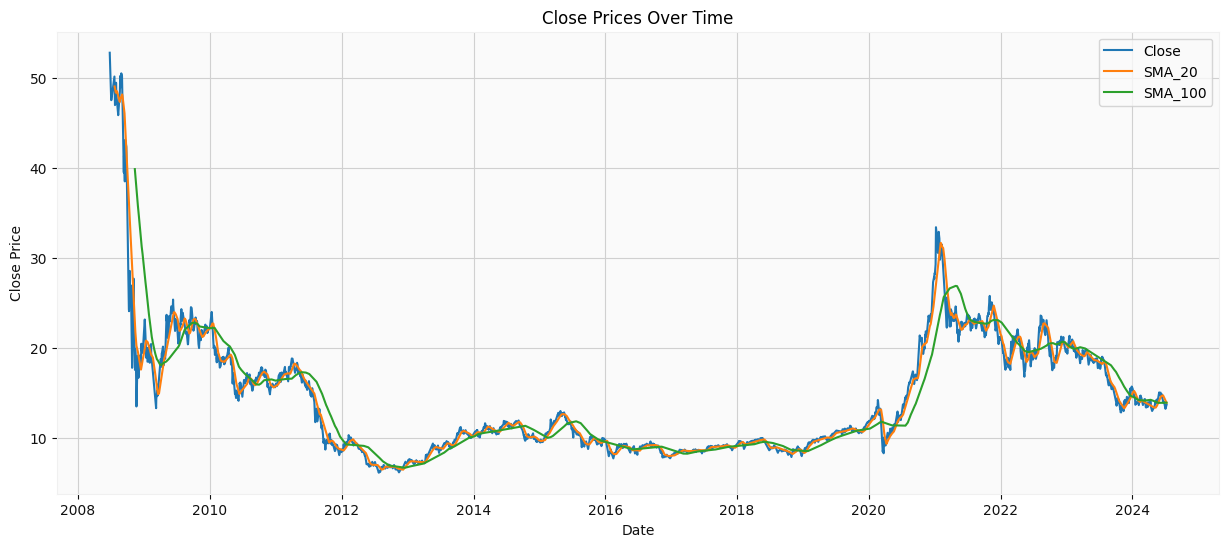

In [89]:
from cProfile import label
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the 'Close' column
plt.figure(figsize=(15, 6))
sns.lineplot(data=prices_df, x=prices_df.index, y='Close', label='Close')
sns.lineplot(data=prices_df, x=prices_df.index, y='SMA_20', label='SMA_20')
sns.lineplot(data=prices_df, x=prices_df.index, y='SMA_100', label='SMA_100')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Prices Over Time')
plt.legend()
plt.show()


Constituents features

In [90]:
import pandas as pd
import os

# Specify the directory where your CSV files are located
directory = 'datasets/Constituents'

# Initialize an empty DataFrame to hold all the merged data
merged_df = pd.DataFrame()

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):  # Assuming all files are CSVs
        file_path = os.path.join(directory, filename)
        # Load the dataset
        df = pd.read_csv(file_path, index_col=0, parse_dates=True)
        
        # Extract the 'Close' column and rename it based on the file name (or any identifier)
        stock_name = filename.split('.')[0]  # Get stock name from filename
        df = df[['Close']].rename(columns={'Close': f'close_{stock_name}_constituent'})
        
        # Merge the dataset with the main DataFrame
        if merged_df.empty:
            merged_df = df
        else:
            merged_df = merged_df.join(df, how='outer')
prices_df = prices_df.join(merged_df, how='inner')

prices_df.tail()

,Open,High,Low,Close,Adj Close,Volume,Close_Lag1,Open_Lag1,High_Lag1,Low_Lag1,...,BB_lower,MOM_10,close_600900_constituent,close_ENPH_constituent,close_ORSTED_constituent,close_0C2_constituent,close_ED_constituent,close_^IBEX_constituent,close_FSLR_constituent,close_VWS_constituent
2024-07-02,13.26,13.42,13.18,13.26,13.26,2154900.0,13.31,13.40,13.49,13.29,...,13.056839,-0.88,29.480000,95.769997,371.200012,10.7,88.970001,10912.799805,216.729996,160.250000
2024-07-03,13.36,13.64,13.34,13.59,13.59,4990500.0,13.26,13.26,13.42,13.18,...,13.038680,-0.55,29.299999,99.169998,383.600006,10.7,88.709999,11056.799805,231.110001,162.800003
2024-07-04,13.36,13.64,13.34,13.59,13.59,4990500.0,13.59,13.36,13.64,13.34,...,13.023517,-0.36,29.389999,NaN,389.500000,10.7,NaN,11066.299805,NaN,163.199997
2024-07-05,13.56,13.73,13.53,13.61,13.61,2619900.0,13.59,13.36,13.64,13.34,...,12.990026,-0.30,29.389999,97.139999,399.500000,10.6,89.269997,11023.500000,222.119995,163.899994
2024-07-08,13.58,13.73,13.55,13.70,13.70,4238997.0,13.61,13.56,13.73,13.53,...,13.003496,-0.35,29.920000,102.809998,387.700012,10.5,88.419998,11022.099609,227.119995,162.550003


Other ETFs

In [91]:
import pandas as pd
import os

# Specify the directory where your CSV files are located
directory = 'datasets/other ETFs'

# Initialize an empty DataFrame to hold all the merged data
merged_df = pd.DataFrame()

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):  # Assuming all files are CSVs
        file_path = os.path.join(directory, filename)
        # Load the dataset
        df = pd.read_csv(file_path, index_col=0, parse_dates=True)
        
        # Extract the 'Close' column and rename it based on the file name (or any identifier)
        stock_name = filename.split('.')[0]  # Get stock name from filename
        df = df[['Close']].rename(columns={'Close': f'close_{stock_name}_etf'})
        
        # Merge the dataset with the main DataFrame
        if merged_df.empty:
            merged_df = df
        else:
            merged_df = merged_df.join(df, how='outer')
prices_df = prices_df.join(merged_df, how='inner')

prices_df.tail()

,Open,High,Low,Close,Adj Close,Volume,Close_Lag1,Open_Lag1,High_Lag1,Low_Lag1,...,close_ENPH_constituent,close_ORSTED_constituent,close_0C2_constituent,close_ED_constituent,close_^IBEX_constituent,close_FSLR_constituent,close_VWS_constituent,close_XLU_etf,close_XLK_etf,close_XLI_etf
2024-07-01,13.40,13.49,13.29,13.31,13.31,3762900.0,13.32,13.66,13.71,13.28,...,97.260002,376.000000,11.2,88.809998,11057.000000,222.710007,162.100006,67.669998,227.940002,120.559998
2024-07-02,13.26,13.42,13.18,13.26,13.26,2154900.0,13.31,13.40,13.49,13.29,...,95.769997,371.200012,10.7,88.970001,10912.799805,216.729996,160.250000,68.019997,229.080002,121.220001
2024-07-03,13.36,13.64,13.34,13.59,13.59,4990500.0,13.26,13.26,13.42,13.18,...,99.169998,383.600006,10.7,88.709999,11056.799805,231.110001,162.800003,68.430000,232.169998,121.660004
2024-07-05,13.56,13.73,13.53,13.61,13.61,2619900.0,13.59,13.36,13.64,13.34,...,97.139999,399.500000,10.6,89.269997,11023.500000,222.119995,163.899994,68.550003,232.880005,121.220001
2024-07-08,13.58,13.73,13.55,13.70,13.70,4238997.0,13.61,13.56,13.73,13.53,...,102.809998,387.700012,10.5,88.419998,11022.099609,227.119995,162.550003,68.620003,234.470001,121.370003


In [92]:
prices_df.to_csv('ICLN_data.csv', index=True)